# 电影评论 (IMDB) 二分类

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
tf.__version__

'2.1.0'

使用 IMDB 数据集，其含有 50000 条严重两极化的评论。

In [3]:
# Load the IMDB data
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(
    # 仅保留训练集中前 10000 个最常出现的单词，低频单词将被舍弃
    num_words=10000)

In [4]:
train_data.shape, test_data.shape

((25000,), (25000,))

每条评论都是单词索引组成的 list。

In [5]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [6]:
train_labels  # 0-negative/1-positive

array([1, 0, 0, ..., 0, 1, 0])

In [7]:
# 由于限定为前 10000 个最常出现的单词，所以单词索引不会超过 10000
max([max(seq) for seq in train_data])

9999

In [8]:
# Retrieves the dictionary mapping word indices back to words.
i = 0
# word 与 index 的对应关系 (dict)
word_index = tf.keras.datasets.imdb.get_word_index()
for (word, index) in word_index.items():
    print(word, index)
    i += 1
    if i == 5:
        break

fawn 34701
tsukino 52006
nunnery 52007
sonja 16816
vani 63951


In [9]:
index_word = dict([(value, key) for (key, value) in word_index.items()])
# 训练集中第一条评论还原
decoded_reviews = ' '.join([index_word.get(i-3, '?') for i in train_data[0]])
decoded_reviews

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

index 减去 3，是因为0、1、2分别是为"padding"（填充）、"start of sequence" （序列开始）、"unknown"（未知词）保留的 index。

**不能将整数序列直接输入到 NN 中，需要将 list 转换为 tensor。**有 2 种方法：

1. 填充 list，使其具有相同的长度，再将列表转换为 `(samples, word_indices)` 的整数 tensor，然后 NN 第一层使用能处理这种整数张量的层（**`Embedding`** 层）。

2. 对 list 进行 one-hot 编码，将其转化为 0 和 1 组成的向量。然后 NN 第一层可以使用 **`Dense`** 层，它能够处理浮点数向量数据。

In [10]:
def vectorize_sequence(sequences, dimension=10000):
    result = np.zeros(shape=(len(sequences), dimension))
    for i, seq in enumerate(sequences):
        result[i, seq] = 1.
    return result


x_train = vectorize_sequence(train_data)  # 训练数据向量化
x_test = vectorize_sequence(test_data)    # 测试数据向量化

In [11]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [12]:
# 将标签向量化
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

y_train

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

这种情况可以使用 `Dense(16, activation='relu')`。

16 个 hidden units 对应的 weights 形状为 `(input_dimenson, 16)`，与 weights 做点积相当于将输入数据投影到 16 维空间中。**<font color='red'>表示空间</font>**可以直观地理解为“NN 学习内部表示时所拥有的自由度”。hidden units 越多（更高维的表示空间），NN 越能够学到更加复杂的表示，但 NN 的计算代价也更大，而且可能会导致过拟合。

**<font color='crimson'>使用 Dense 层堆叠的 NN，需要确定</font>**

- NN 有多少层


- 每层有多少个 hidden units

In [13]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
# now the model will take as input arrays of shape (*, 10000)
# and output arrays of shape (*, 16)
model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(10000, )))
# after the first layer, you don't need to specify the size of the input anymore:
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


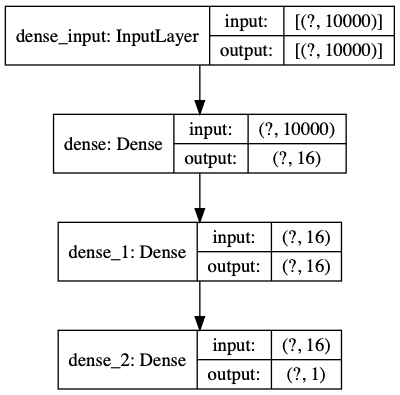

In [14]:
# Converts a Keras model to dot format and save to a file.
tf.keras.utils.plot_model(model, 'figs/chap03-figs/model_1.png', show_shapes=True)

<div class="alert alert-blokc alert-info">
    <center><b>为什么使用 activation?</b></center>

如果没有 activation，Dense 层只包含 2 个线性运算——点积和加法。这样 Dense 层只能学习输入数据的<b>线性变换</b> (仿射变换)：该层的假设空间是从输入数据到 16 维空间所有可能的线性变换合集。这种假设空间非常有限，无法利用多个表示层的优势，因为多个线性层堆叠实现的仍然是线性运算，添加层数并不会扩展假设空间。

为了得到更加丰富的假设空间，从而充分利用多层表示的优势，需要添加非线性或激活函数。
</div>

这是一个二分类问题，NN 输出是一个概率，那么最好使用 `binary_crossentropy` 损失。

对于输出概率值的模型，**<font color='red'>交叉熵 (crossentropy)</font>**往往是最好的选择，其**用于衡量概率分布之间的距离**。

In [15]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [16]:
# Or
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[tf.keras.metrics.binary_accuracy])

In [17]:
x_val = x_train[:10000]
x_train_partial = x_train[10000:]

y_val = y_train[:10000]
y_train_partial = y_train[10000:]

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train_partial,
                    y_train_partial,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 137us/sample - loss: 0.5074 - acc: 0.7865 - val_loss: 0.3852 - val_acc: 0.8614
Epoch 2/20
15000/15000 [==============================] - 1s 70us/sample - loss: 0.2972 - acc: 0.9035 - val_loss: 0.2995 - val_acc: 0.8910
Epoch 3/20
15000/15000 [==============================] - 1s 71us/sample - loss: 0.2169 - acc: 0.9290 - val_loss: 0.2777 - val_acc: 0.8917
Epoch 4/20
15000/15000 [==============================] - 1s 71us/sample - loss: 0.1737 - acc: 0.9439 - val_loss: 0.2892 - val_acc: 0.8825
Epoch 5/20
15000/15000 [==============================] - 1s 71us/sample - loss: 0.1377 - acc: 0.9557 - val_loss: 0.2908 - val_acc: 0.8817
Epoch 6/20
15000/15000 [==============================] - 1s 71us/sample - loss: 0.1132 - acc: 0.9650 - val_loss: 0.2983 - val_acc: 0.8838
Epoch 7/20
15000/15000 [==============================] - 1s 71us/sample - loss: 0.0920 - acc: 0.9735 - val_loss: 0

In [18]:
history.params

{'batch_size': 512,
 'epochs': 20,
 'steps': 30,
 'samples': 15000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}

In [19]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [20]:
history.model

`model.fit()` 返回了一个 **`History`** 对象。

In [21]:
# a record of training loss values and metrics values at successive epochs, 
# as well as validation loss values and validation metrics values (if applicable).
history_dict = history.history  # 包含训练过程中的所有数据
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [33]:
def plot_history(history):
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = [i + 1 for i in history.epoch]

    # Plot the results
    plt.figure(figsize=(12, 3.8))
    plt.subplot(121)
    plt.plot(epochs, loss_values, 'b-', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b.-', label='Val loss')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=14)
    plt.title('Training and validation loss', fontsize=16)

    plt.subplot(122)
    plt.plot(epochs, acc, 'b-', label='Training acc')
    plt.plot(epochs, val_acc, 'b.-', label='Val acc')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs)
    plt.ylabel('Acc', fontsize=12)
    plt.legend(fontsize=14)
    plt.title('Training and validation acc', fontsize=16)

    plt.show()

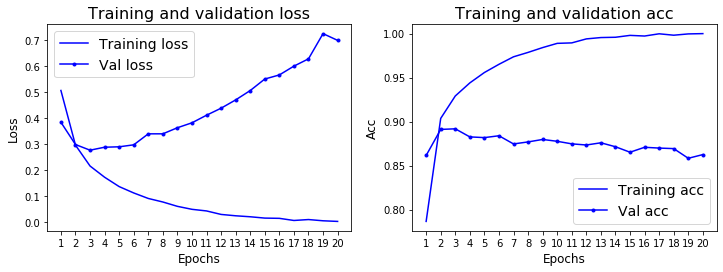

In [34]:
plot_history(history)

训练损失每个 epoch 都在降低，训练精度每个 epoch 都在提升。但验证损失和验证精度并非如此。

这里过拟合了。可以在第 3 个 epoch 停止训练。

In [35]:
# 从头训练一个新 NN，训练 4 个 epoch
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(10000, )))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train_partial,
                    y_train_partial,
                    epochs=4,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 2s 103us/sample - loss: 0.5155 - acc: 0.7831 - val_loss: 0.3884 - val_acc: 0.8652
Epoch 2/4
15000/15000 [==============================] - 1s 73us/sample - loss: 0.3096 - acc: 0.9036 - val_loss: 0.3220 - val_acc: 0.8749
Epoch 3/4
15000/15000 [==============================] - 1s 76us/sample - loss: 0.2267 - acc: 0.9259 - val_loss: 0.2804 - val_acc: 0.8928
Epoch 4/4
15000/15000 [==============================] - 1s 67us/sample - loss: 0.1790 - acc: 0.9417 - val_loss: 0.2867 - val_acc: 0.8859


In [37]:
results = model.evaluate(x_test, y_test)
results

25000/25000 [==============================] - 1s 41us/sample - loss: 0.3088 - acc: 0.8749


[0.30878005620002746, 0.87488]

In [38]:
model.predict(x_test)  # 每个评论为正面的可能性

array([[0.24500553],
       [0.9981419 ],
       [0.76635385],
       ...,
       [0.06869619],
       [0.12302679],
       [0.41749144]], dtype=float32)

**<font color='crimson'>Summary:</font>**

- 通常需要对数据进行预处理，以便将其转换为张量输入到 NN 中。


- 二分类问题，NN 的最后一层应该是 `Dense(1, activation='sigmoid')`。


- 对于二分类问题的 `sigmoid` 标量输出，应该使用 binary_crossentropy (`tf.keras.losses.binary_crossentropy`) 损失函数。


- 无论问题是什么，rmsprop (`tf.keras.optimizers.RMSprop(lr=0.001)`) 通常都是最好的选择。


- 一定要监控模型在训练集之外的数据上的性能，以免过拟合。